# Urban Sound Classification

This dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music.

This sound classification challenge contains 5435 training samples with labels and 3297 unlabelled test samples. This classification challenge is hosted on Analytics Vidhya which can be found [here](https://datahack.analyticsvidhya.com/contest/practice-problem-urban-sound-classification).

In [2]:
import IPython.display as ipd
import librosa
import librosa.display as libd

import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The dataset can be downloaded from [here](https://drive.google.com/drive/folders/0By0bAi7hOBAFUHVXd1JCN3MwTEU).

The train csv file contains the audio ID (which is also the file name) and the class it belongs to.

The test csv file contains the audio ID.

In [3]:
# Loading the train and test csv files
df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
df.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


Let's first try to explore a single audio sample.

In [4]:
# Playing a sample of drilling sound excerpt
ipd.Audio('./data/Train/2.wav')

In [5]:
# Loading the sample using librosa
ex_data, ex_sr = librosa.load('./data/Train/2.wav')
ex_data.shape, ex_sr

((88200,), 22050)

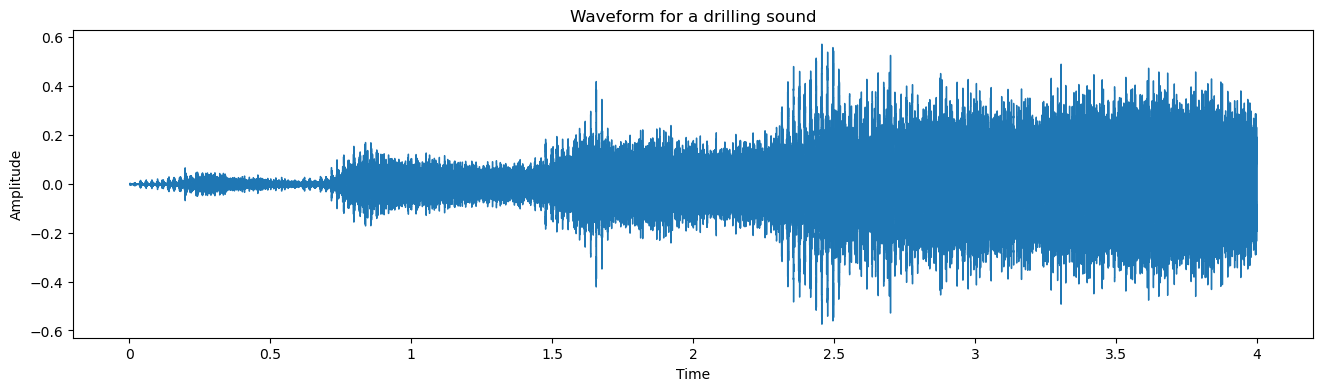

In [6]:
# Seeing how the sound looks like on a wave plot
fig, ax = plt.subplots(figsize = (16, 4))
librosa.display.waveshow(ex_data, sr = ex_sr)
plt.ylabel('Amplitude')
plt.title('Waveform for a drilling sound')
plt.show()

We can see a pattern where the amplitude is low at the begining and high later on. 

Let's plot waveforms for all the different audio exerpts in this dataset.

In [7]:
# Getting a random audio file for each class
np.random.seed(0)
random_class_df = pd.DataFrame(df.groupby('Class')['ID'].apply(np.random.choice).reset_index())
random_class_df

,Class,ID
0,air_conditioner,8093
1,car_horn,3758
2,children_playing,2808
3,dog_bark,5329
4,drilling,130
5,engine_idling,3861
6,gun_shot,1341
7,jackhammer,7629
8,siren,977
9,street_music,6855


In [8]:
# Reading data for the random audio files selected
random_class_data = []

for idx in random_class_df.index:
    file_name = str(random_class_df['ID'][idx]) + '.wav'
    wav, sr = librosa.load('./data/Train/' + file_name)
    
    random_class_data.append(wav)

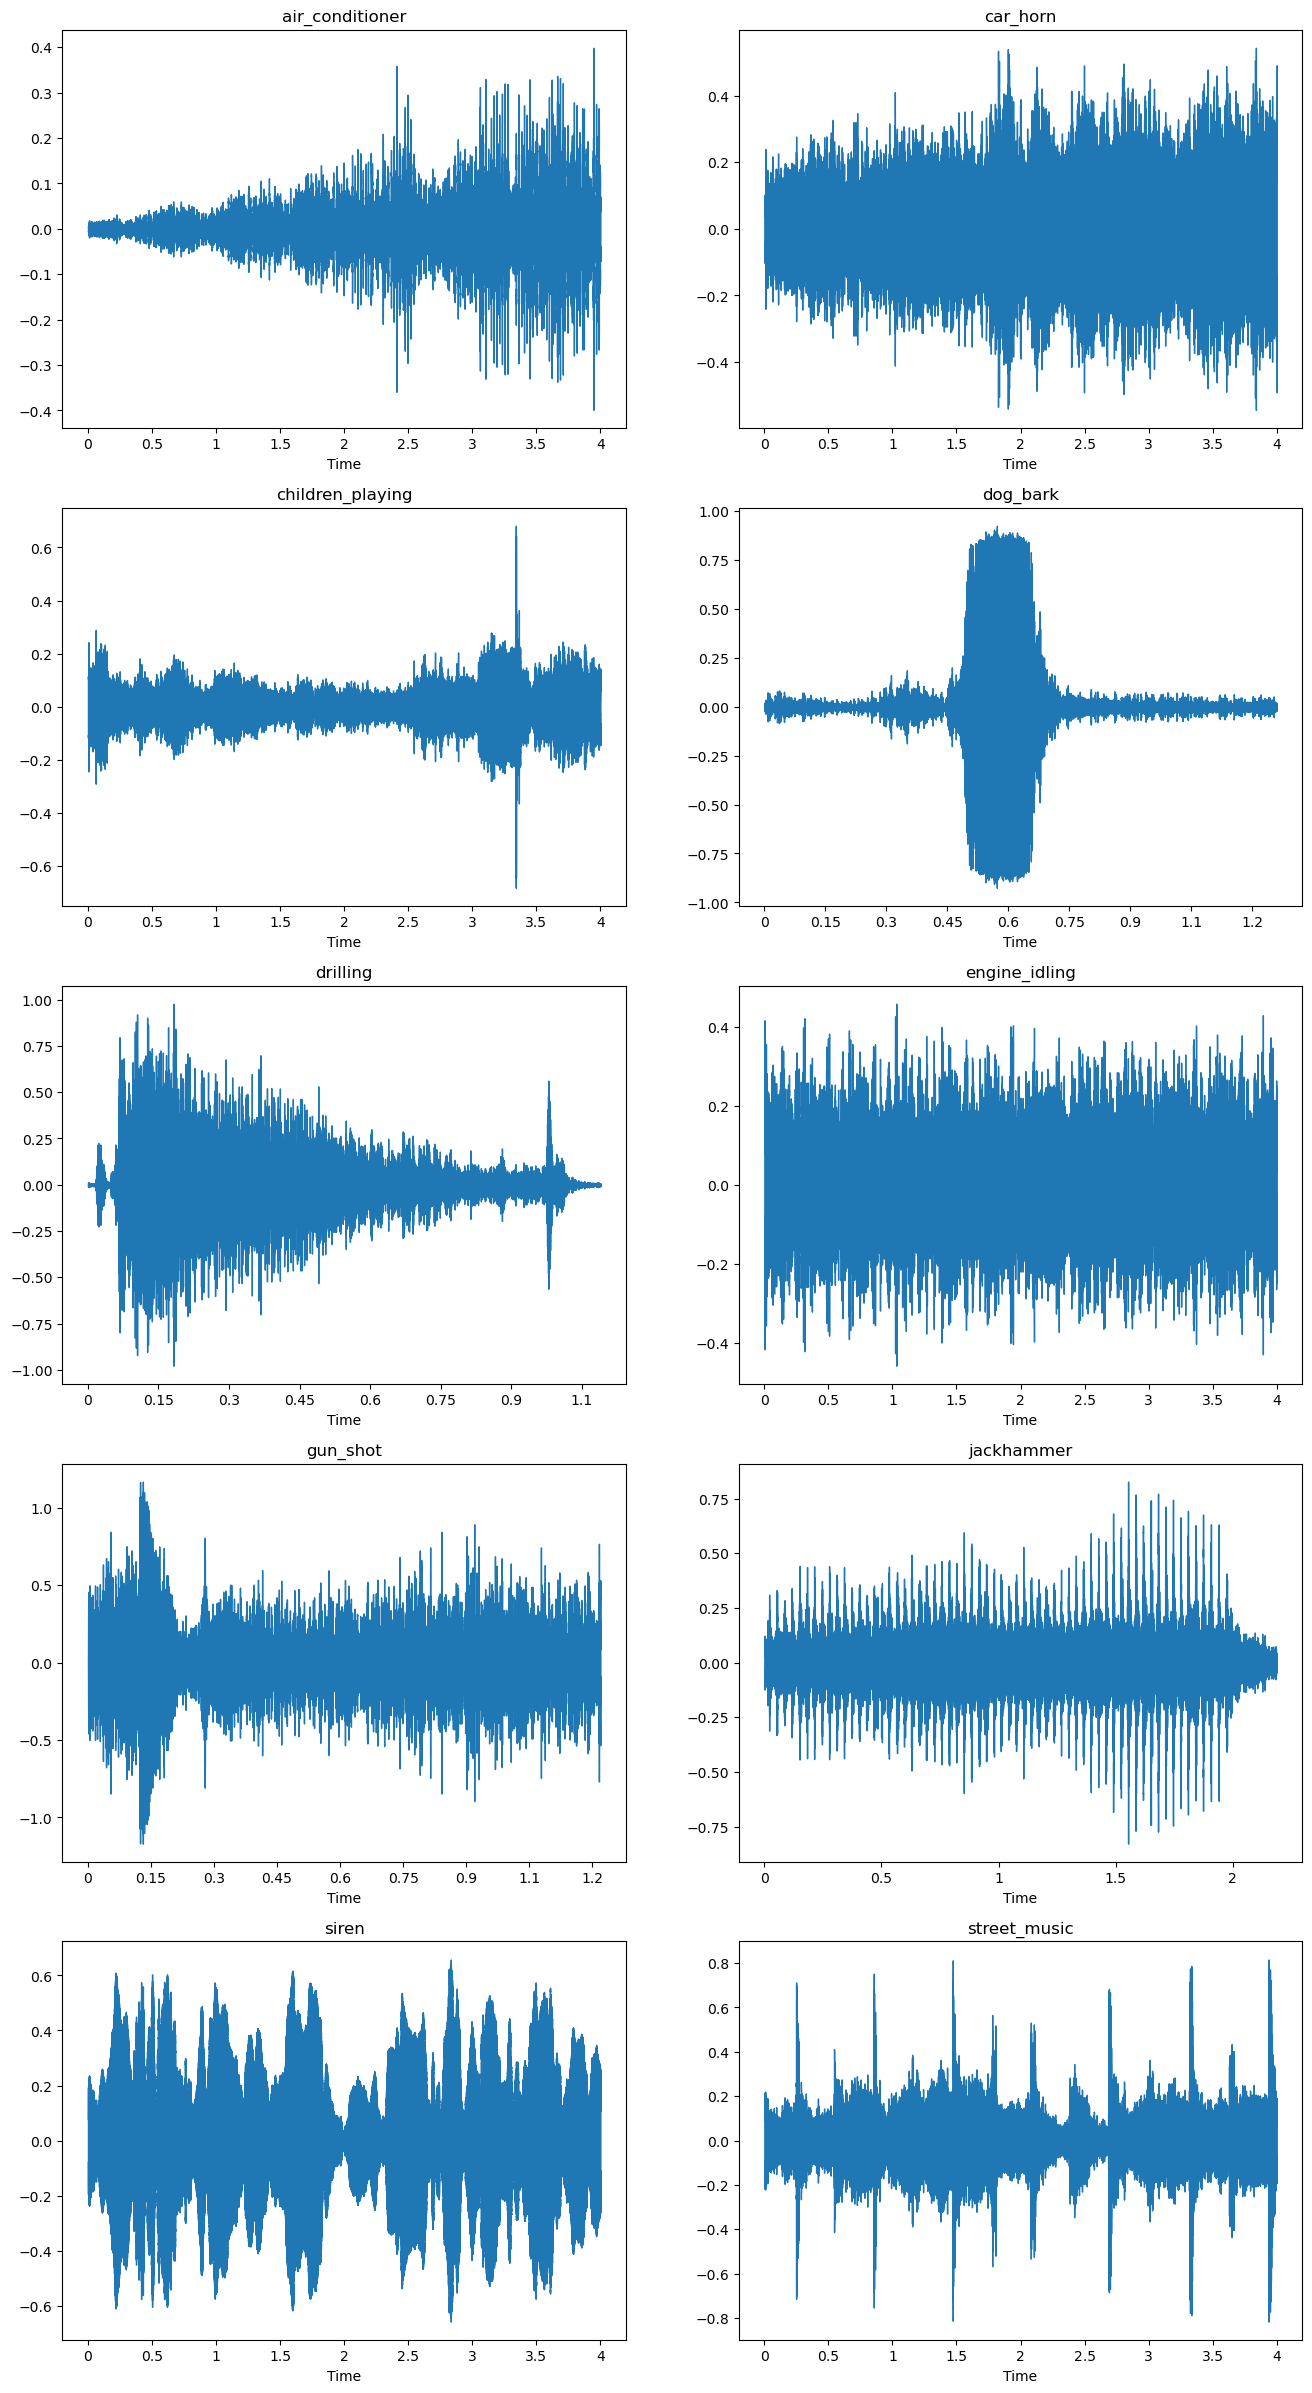

In [9]:
# Plotting the waveforms for each class
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (16, 30))
for i in range(5):
    librosa.display.waveshow(random_class_data[2*i], sr = sr, ax = ax[i][0])
    ax[i][0].set_title(random_class_df['Class'][2*i])
    
    librosa.display.waveshow(random_class_data[2*i + 1], sr = sr, ax = ax[i][1])
    ax[i][1].set_title(random_class_df['Class'][2*i + 1])
    
plt.show()

We can see different patterns for different audio sounds but it might be difficult to classify audio samples based on these patters alone, for example engine_ideling and jackhammer. 

So we extract features from the auido. Each audio is a mix of soundwaves of different frequencies. We can use fast fourier transform to decompose these audio samples into different frequencies.

We will also convert these frequencies into mel scale and amplitude into decibel scale as this mimics our perception of sound.

In [10]:
def get_fixed_audio_len(wav, sr, audio_len):
    '''
    Converts a time-series audio to a fixed length either by padding or trimming
    
    Parameters
    -------------
    wav: Audio time-series
    
    sr: Sample rate
    
    audio_len: The fixed audio length needed in seconds
    '''
    if wav.shape[0] < audio_len * sr:
        wav = np.pad(wav, int(np.ceil((audio_len * sr - wav.shape[0])/2)), mode = 'reflect')
    wav = wav[:audio_len * sr]
    
    return wav

In [11]:
def get_melspectrogram_db(wav, sr, audio_len = 4, n_fft = 2048, hop_length = 512, 
                          n_mels = 128, fmin = 20, fmax = 8300, top_db = 80):
    '''
    Decomposes the audio sample into different frequencies using fourier transform 
    and converts frequencies to mel scale and amplitude to decibel scale.
    
    Parameters
    -------------------
    wav: Audio time-series
    
    sr: Sample rate
    
    audio_len: The fixed length of audio in seconds
    
    n_fft: Length of the Fast Fourier Transform window
    
    hop_length: Number of samples between successive frames
    
    n_mels: Number of mel filters, which make the height of spectrogram image
    
    fmin: Lowest frequency
    
    fmax: Heighest frequency
    
    top_db: Threashold of the decibel scale output
    '''
    wav = get_fixed_audio_len(wav, sr, audio_len)
        
    spec = librosa.feature.melspectrogram(y = wav, sr = sr, n_fft = n_fft, hop_length = hop_length, 
                                               n_mels = n_mels, fmin = fmin, fmax = fmax)
    
    spec = librosa.power_to_db(spec, top_db = top_db)
    return spec

Once we get the spectrogram, we need to convert that to an image in order to plot it and train our model.

To do this, we first normalize the spectrogram using z-score normalization and then use min-max scaling to scale the values to be between 0 and 255.

In [12]:
def spec_to_image(spec):
    '''
    Converts the spectrogram to an image
    
    Parameters
    -------------
    spec: Spectrogram
    '''
    eps=1e-6
    
    # Z-score normalization
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    
    # Min-max scaling
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    
    return spec_scaled

In [13]:
# Getting the spectrogram and the image of spectogram from time-series audio
random_class_spec = [get_melspectrogram_db(wav, sr = sr) for wav in random_class_data]
random_class_spec_img = [spec_to_image(spec) for spec in random_class_spec]

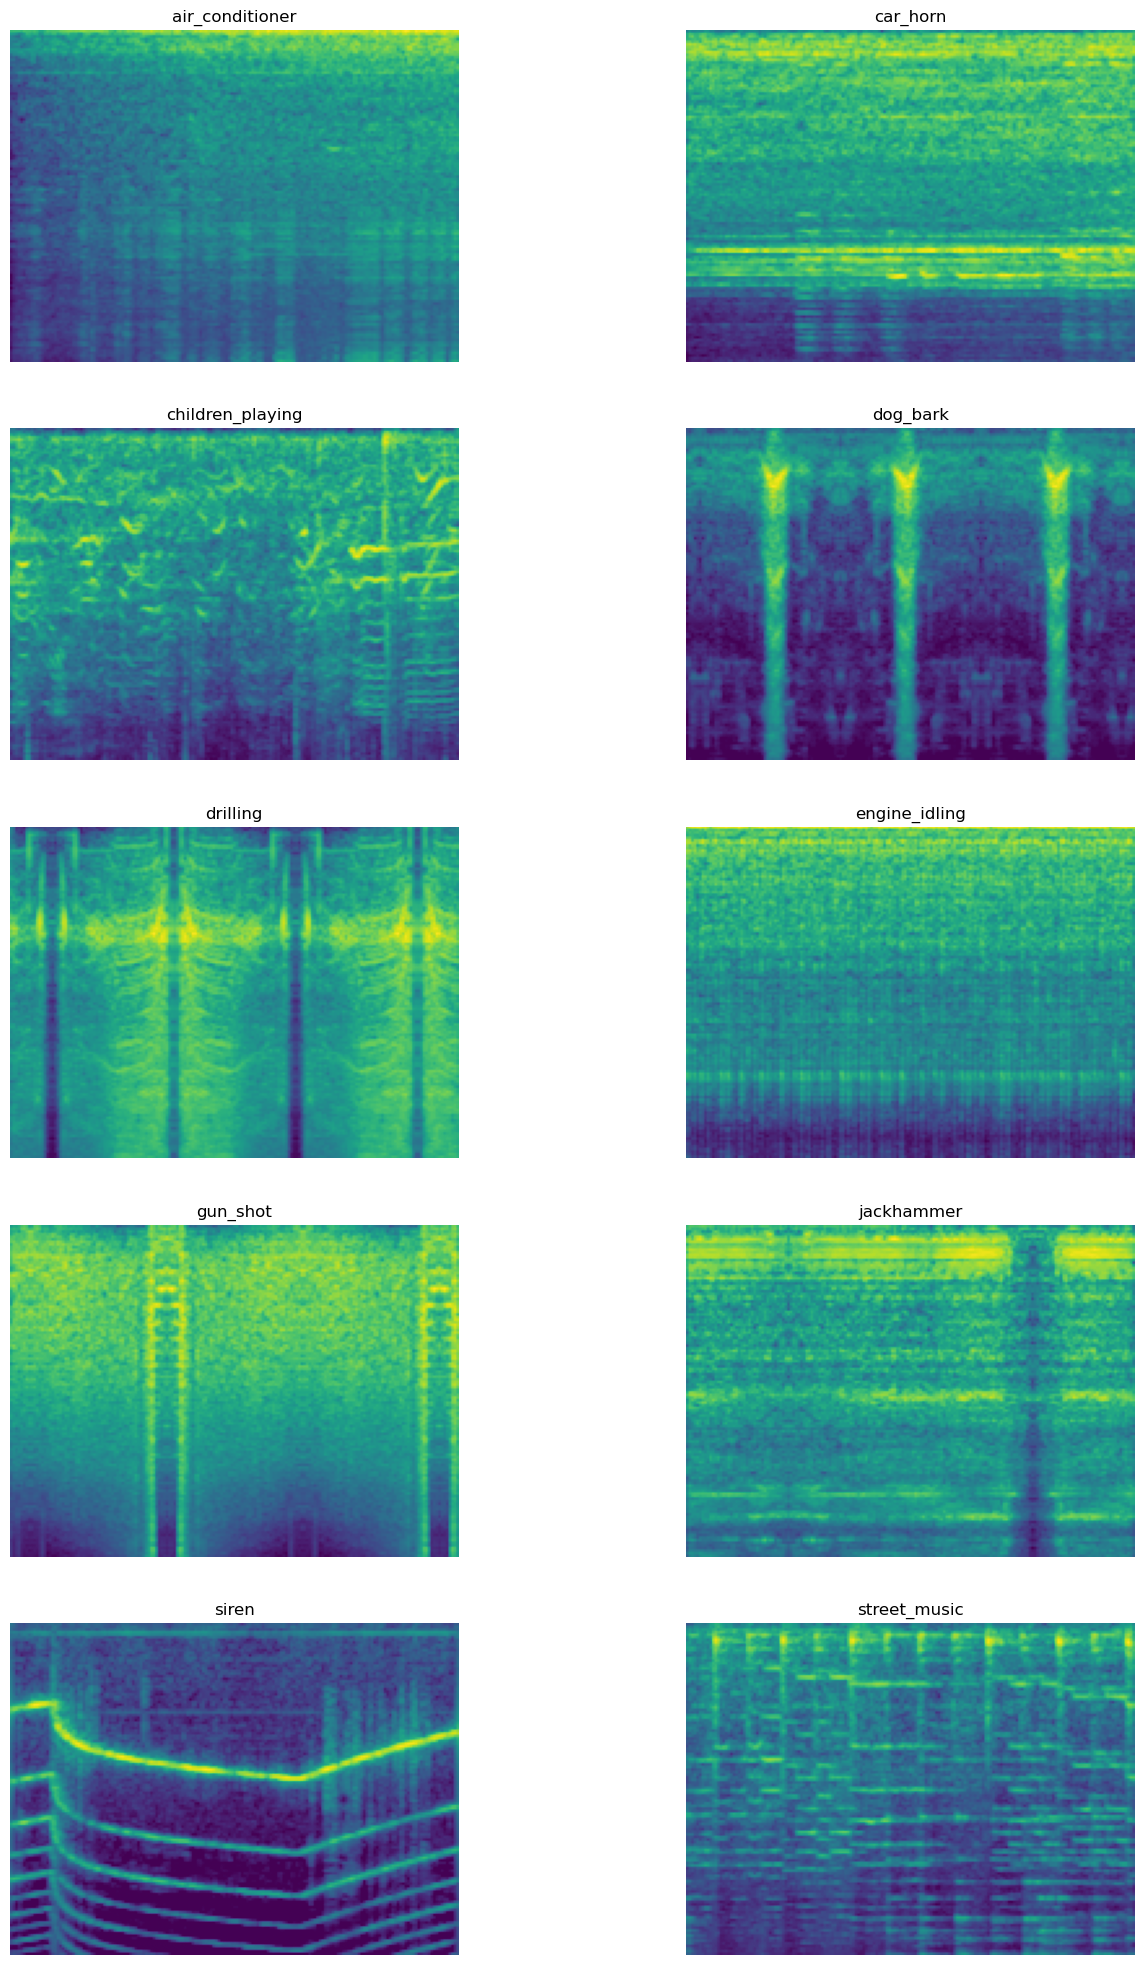

In [14]:
ax = utils.plot_images(random_class_spec_img, ncols = 2, figsize = (16, 25), bgr2rgb = False, axis_style = 'off')
for i in range(5):
    ax[i][0].set_title(random_class_df['Class'][2*i])
    ax[i][1].set_title(random_class_df['Class'][2*i + 1])

plt.show()

## Data Preprocessing

We've explored just a sample of the data until now. Let's do that for the entire dataset!

First, we split the training data into train and validation sets since we do not have the labels for the test set. We will split the data such that both the sets have roughly equal percentages of the same class.

In [15]:
# Existing ratios of classes in the data
df.groupby('Class')['ID'].agg('count') / len(df)

Class
air_conditioner     0.110396
car_horn            0.056302
children_playing    0.110396
dog_bark            0.110396
drilling            0.110396
engine_idling       0.114811
gun_shot            0.042318
jackhammer          0.122907
siren               0.111684
street_music        0.110396
Name: ID, dtype: float64

In [16]:
# Converting classes into numeric format
df['numeric_class'] = df['Class'].astype('category').cat.codes
df

,ID,Class,numeric_class
0,0,siren,8
1,1,street_music,9
2,2,drilling,4
3,3,siren,8
4,4,dog_bark,3
...,...,...,...
5430,8725,engine_idling,5
5431,8726,dog_bark,3
5432,8727,engine_idling,5
5433,8728,engine_idling,5


In [17]:
# Get the dictionary of classes based on their numeric value
classes = dict(df.groupby('numeric_class').agg('max')['Class'])

In [18]:
def train_val_split(df, target_col, split_size = 0.33, seed = 0):
    '''
    Splits a dataframe into training and validation dataframes with 
    approximately equal proportions of target column classes.
    
    Parameters
    --------------
    df: Dataframe to split
    
    target_col: The column to consider for equal split ratio
    
    split_size: The ratio of validation dataframe
    
    seed: Seed for random sample
    '''
    train_df = pd.DataFrame(columns = df.columns)
    val_df = pd.DataFrame(columns = df.columns)
    
    for grp in set(df[target_col]):
        curr_grp_data = df[df[target_col] == grp]
        
        # Shuffle the dataframe
        curr_grp_data = curr_grp_data.sample(frac = 1, random_state = seed).reset_index(drop = True) 
        
        split_idx = int(split_size * curr_grp_data.shape[0])
        val_df = pd.concat([val_df,curr_grp_data[:split_idx]])
        train_df = pd.concat([train_df, curr_grp_data[split_idx:]])
    
    train_df = train_df.sample(frac = 1, random_state = seed).reset_index(drop = True)
    val_df = val_df.sample(frac = 1, random_state = seed).reset_index(drop = True)
    
    return train_df, val_df

In [19]:
# Splitting the data with 20% validation set
train_df, val_df = train_val_split(df, 'Class', split_size = 0.2, seed = 0)
train_df.shape, val_df.shape

((4350, 3), (1085, 3))

## Using an Artificial Neural Network on time-series audio data

Let's first try to use just the time series data to train our neural network. I don't expect to get good results as the number of training examples would be around 4350 and there would be 88200 features per training example. The number of features is nearly 20 times the number of training examples which would result in a poor model.

But it would be interesting to see the results as we move to more sophisticated models.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

In [21]:
# Defining dataset batch size
BATCH_SIZE = 32

In [22]:
def load_data(df, id_col, label_col = None, data_path = './', audio_len = 4):
    '''
    Loads the audio time-series data
    
    Parameters
    -------------
    df: The dataframe that contains the file name and corresponding label
    
    id_col: The column name that contains the file name
    
    label_col: The column name that contains the label
    '''
    audio_time_series = []
    sample_rates = []
    labels = []
    
    tot = len(df)
    curr = 0
    
    for idx in df.index:
        try:
            file_name = str(df[id_col][idx]) + '.wav'
            wav, sr = librosa.load(data_path + '/' + file_name)
            
            wav = get_fixed_audio_len(wav, sr, audio_len)
    
            audio_time_series.append(wav)
            sample_rates.append(sr)
            
            if label_col is not None:
                labels.append(df[label_col][idx])
            
            curr += 1
            utils.drawProgressBar(curr, tot, barLen = 40)
        
        except KeyboardInterrupt:
            print('KeyBoardInterrupt')
            break
        
        except Exception:
            print("Couldn't read file", df[id_col][idx])
            curr += 1
            
    print('\n')
    return np.stack(audio_time_series, axis = 0), np.array(sample_rates), np.array(labels)

In [23]:
train_time_series, train_sr, train_labels = load_data(train_df, 'ID', 'numeric_class', './data/Train')

val_time_series, val_sr, val_labels = load_data(val_df, 'ID', 'numeric_class', './data/Train')

Progress: [========================================] 4350/4350

Progress: [========================================] 1085/1085



In [24]:
train_time_series.shape, val_time_series.shape

((4350, 88200), (1085, 88200))

In [25]:
# Convert numpy arrays to torch tensors
train_time_series = torch.from_numpy(train_time_series)
train_labels = torch.from_numpy(train_labels).long()

val_time_series = torch.from_numpy(val_time_series)
val_labels = torch.from_numpy(val_labels).long()

# Create data loaders
train_time_series = data_utils.TensorDataset(train_time_series, train_labels)
train_loader = data_utils.DataLoader(train_time_series, batch_size = BATCH_SIZE, shuffle = True)

val_time_series = data_utils.TensorDataset(val_time_series, val_labels)
val_loader = data_utils.DataLoader(val_time_series, batch_size = BATCH_SIZE, shuffle = True)

Building a neural network architecture to train the data on

In [26]:
# Defining training parameters
LEARNING_RATE = 0.001
EPOCHS = 10
NUM_CLASSES = len(classes)
N_FEATURES = train_time_series[0][0].shape[0]

In [27]:
# Defining our neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # Layer 1 with 1024 neurons
        self.fc1 = nn.Linear(in_features = N_FEATURES, out_features = 1024)
        
        # Layer 2 with 512 neurons
        self.fc2 = nn.Linear(in_features = 1024, out_features = 512)
        
        # Layer 3 with 128 neurons
        self.fc3 = nn.Linear(in_features = 512, out_features = 128)
        
        # Layer 4, output layer
        self.fc4 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

Once we've built our architecture, let's proceed to defining a loss function and optimizer for our model. We've chosen `nn.CrossEntropyLoss()` as our loss function because it combines `nn.NLLoss()` and `nn.SoftMax()` which is why we do not have a softmax activation defined in the `forward()` function definition above.

In [28]:
# Defining loss and optimizer
net = NeuralNet()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE)

Now train the model

In [29]:
num_train_batches = len(train_loader)
loss_hist = []
acc_hist = []

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ":")
    
    for i, batch in enumerate(train_loader):
        # batch is a tuple of input data and labels
        inputs, labels = batch
        
        # Running forward pass
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct/total
        
        # Printing progress
        utils.drawProgressBar((i+1), num_train_batches, 
                              '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n\n')
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())

Epoch 1:
Progress: [====================] 136/136	 loss: 2.3374 	 acc: 0.1667


Epoch 2:
Progress: [====================] 136/136	 loss: 1.5018 	 acc: 0.5667


Epoch 3:
Progress: [====================] 136/136	 loss: 0.6642 	 acc: 0.7667


Epoch 4:
Progress: [====================] 136/136	 loss: 0.4618 	 acc: 0.8667


Epoch 5:
Progress: [====================] 136/136	 loss: 0.1273 	 acc: 0.9667


Epoch 6:
Progress: [====================] 136/136	 loss: 0.0286 	 acc: 1.0000


Epoch 7:
Progress: [====================] 136/136	 loss: 0.2696 	 acc: 0.9667


Epoch 8:
Progress: [====================] 136/136	 loss: 0.1775 	 acc: 0.9333


Epoch 9:
Progress: [====================] 136/136	 loss: 0.0799 	 acc: 1.0000


Epoch 10:
Progress: [====================] 136/136	 loss: 0.6706 	 acc: 0.9667




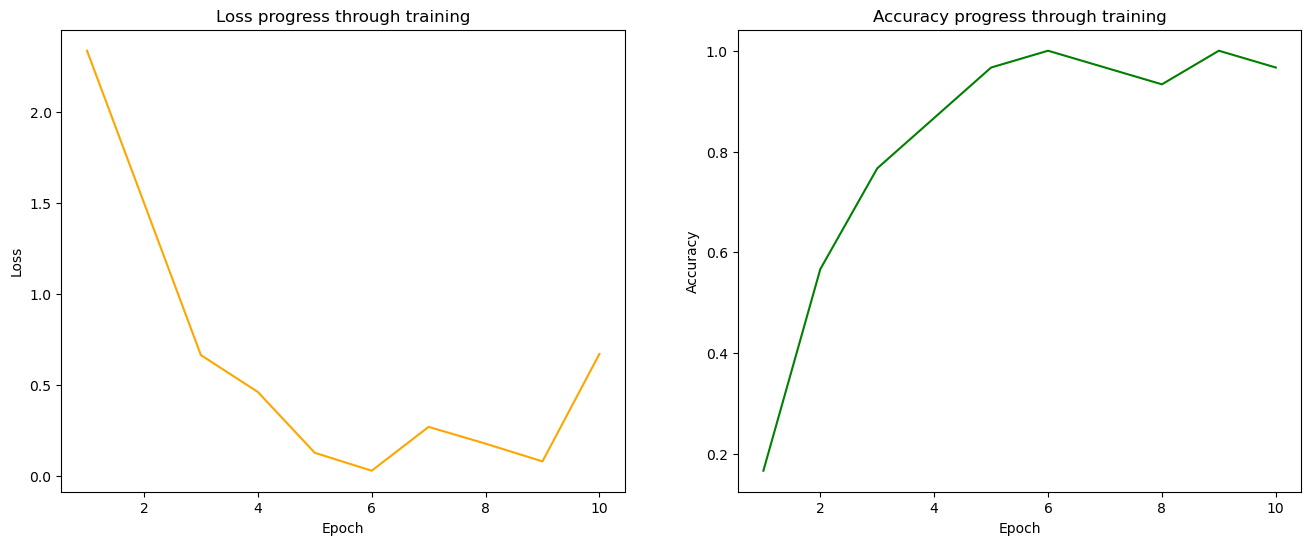

In [30]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

In [31]:
def evaluate(model, test_loader):
    '''
    Returns the accuracy and loss of a model
    
    Parameters
    --------------
    model: A PyTorch neural network
    
    test_loader: The test dataset in the form of torch DataLoader
    '''
    model.eval()
    num_test_batches = len(test_loader)
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Printing progress
            utils.drawProgressBar((i+1), num_test_batches)
        
        accuracy = correct/total
        test_loss = total_loss/num_test_batches
    
    return accuracy, test_loss

In [32]:
val_acc, val_loss = evaluate(net, val_loader)

print("\n\nValidation accuracy: {:.4f}".format(round(val_acc, 4)))
print("Validation loss: {:.4f}".format(round(val_loss, 4)))

Progress: [=>                  ] 2/34

Progress: [====================] 34/34

Validation accuracy: 0.2000
Validation loss: 6.0459


The validation accuracy is horrible (~20%) because the ANN overfitted the data. We can see that after the 5th epoch the loss line was flat.

Create a solution for the test set to submit it on the challenge platform.

In [33]:
# Loading the data
test_time_series, test_sr, _ = load_data(test_df, id_col = 'ID', data_path = './data/Test')

test_time_series = torch.from_numpy(test_time_series)

Progress: [>                                       ] 1/3297

Progress: [========================================] 3297/3297



In [34]:
predictions = []
test_len = len(test_df)

with torch.no_grad():
    for idx in test_df.index:
        data_input = test_time_series[idx].unsqueeze(0)
        output = net(data_input)
        _, predicted = torch.max(output, dim=1)
        predictions.append(classes[predicted[0].item()])

        utils.drawProgressBar(idx + 1, test_len, barLen=40)

test_df["Class"] = pd.Series(predictions)
test_df.to_csv("./predictions/TestPredUsingTimeSeriesNN.csv", index=False)

Progress: [>                                       ] 5/3297

Progress: [========================================] 3297/3297

## Training a Convolutional neural network on spectrogram images

In [35]:
# Checking the sample rate of the audio files in train and validation sets
set(train_sr), set(val_sr)

({22050}, {22050})

All the files in train and validation sets have the same sample rate of 22050.

In [36]:
train_sr = 22050
val_sr = 22050

In [37]:
def get_spec_loader(audio_time_series, sr, batch_size, shuffle = False):
    '''
    Returns data loader of spectrogram images
    
    Parameters
    ------------
    audio_time_series: Tensor Dataset with wav, label iterables
    
    sr: Sample rate
    
    batch_size: The batch size of data loader
    '''
    audio_spec_img = []
    labels = []
    curr = 0
    tot = len(audio_time_series)

    for wav, label in audio_time_series:
        spec_img = spec_to_image(get_melspectrogram_db(wav.numpy(), sr))
        spec_img = np.expand_dims(spec_img, axis = 0)
        audio_spec_img.append(spec_img)
        labels.append(label)

        curr += 1
        utils.drawProgressBar(curr, tot, barLen = 40)

    audio_spec_img = torch.Tensor(audio_spec_img)
    audio_spec_img = audio_spec_img / 255
    
    labels = torch.Tensor(labels).long()

    audio_spec_img = data_utils.TensorDataset(audio_spec_img, labels)
    audio_loader = data_utils.DataLoader(audio_spec_img, batch_size = batch_size, shuffle = shuffle)
    
    return audio_loader

In [38]:
# Getting the spectrogram image for each audio in train set
train_loader = get_spec_loader(train_time_series, train_sr, BATCH_SIZE, shuffle = True)

Progress: [>                                       ] 5/4350

Progress: [========================================] 4350/4350

C:\Users\duttas\AppData\Local\Temp\ipykernel_16680\1341925151.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  audio_spec_img = torch.Tensor(audio_spec_img)


In [39]:
# Getting the spectrogram image for each audio in validation set
val_loader = get_spec_loader(val_time_series, val_sr, BATCH_SIZE)

Progress: [========================================] 1085/1085

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Layer 1, Input shape (1, 128, 173) ->  Output shape (8, 62, 84)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (5, 6)), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = (2, 2)))
        
        # Layer 2, Input shape (8, 62, 84) -> Output shape (16, 30, 41)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3)), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = (2, 2)))
        
        # Layer 3, Input shape (16, 30, 41) -> Output shape (64, 10, 15)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (6, 7)), 
            nn.ReLU(), 
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (6, 6)), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = (2, 2)))
        
        # Fully Connected layer 1, Input features 64 * 10 * 15 -> Output features 512
        self.fc1 = nn.Linear(in_features = 64 * 10 * 15, out_features = 512)
        
        # Fully Connected layer 2, Input features 512 -> Output features 256
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        
        # Fully Connected layer 3, Input features 256 -> Output features 128
        self.fc3 = nn.Linear(in_features = 256, out_features = 128)
        
        # Fully Connected layer 4, Input features 128 -> Output features 10
        self.fc4 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        n_features = 1
        for s in size:
            n_features = n_features * s
        
        return n_features

In [41]:
# Defining loss and optimizer
model = ConvNet()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [42]:
THRESHOLD = 0.001  # Threshold for early stopping
THRESH_EPOCHS = 3 # Number of epochs loss does not decrease before early stopping
PATH = './models/ConvNet.pth.tar'  # Path to save the best model

loss_hist = []
acc_hist = []
num_train_batches = len(train_loader)

early_stop_epoch = 0
lowest_loss = np.inf

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ":")
    
    for i, batch in enumerate(train_loader):
        # batch is a tuple of data and labels
        data, labels = batch
        
        # Running forward pass
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total
        
        # Printing progress
        utils.drawProgressBar((i + 1), num_train_batches, 
                              '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n')
    
    if abs(lowest_loss - loss.item()) < THRESHOLD:
        early_stop_epoch += 1
        print('Loss did not decrease from ' + str(lowest_loss))
    
    else:
        print('Loss decreased from {:.4f} to {:.4f}, saving model to {}'.format(
            round(lowest_loss, 4), round(loss.item(), 4), PATH))
        
        lowest_loss = loss.item()
        early_stop_epoch = 0
        torch.save({'state_dict': model.state_dict()}, PATH)
        
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())
    print('\n\n')

Epoch 1:
Progress: [====================] 136/136	 loss: 2.0753 	 acc: 0.2667

Loss decreased from inf to 2.0753, saving model to ./models/ConvNet.pth.tar



Epoch 2:
Progress: [====================] 136/136	 loss: 1.8648 	 acc: 0.3333

Loss decreased from 2.0753 to 1.8648, saving model to ./models/ConvNet.pth.tar



Epoch 3:
Progress: [====================] 136/136	 loss: 1.6014 	 acc: 0.4333

Loss decreased from 1.8648 to 1.6014, saving model to ./models/ConvNet.pth.tar



Epoch 4:
Progress: [====================] 136/136	 loss: 1.1652 	 acc: 0.6333

Loss decreased from 1.6014 to 1.1652, saving model to ./models/ConvNet.pth.tar



Epoch 5:
Progress: [====================] 136/136	 loss: 1.0069 	 acc: 0.6667

Loss decreased from 1.1652 to 1.0069, saving model to ./models/ConvNet.pth.tar



Epoch 6:
Progress: [====================] 136/136	 loss: 0.9982 	 acc: 0.7000

Loss decreased from 1.0069 to 0.9982, saving model to ./models/ConvNet.pth.tar



Epoch 7:
Progress: [=================

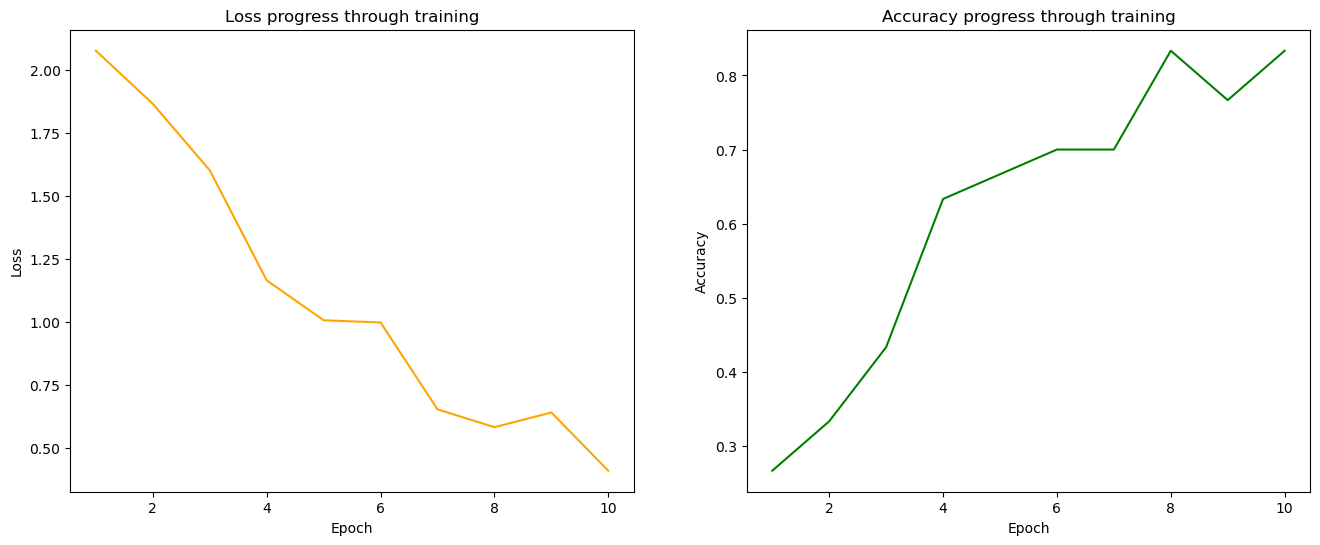

In [43]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

In [44]:
# Loading the best model
model = ConvNet()
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [45]:
# Getting the validation accuracy and loss
val_acc, val_loss = evaluate(model, val_loader)

print("\n\nValidation accuracy: {:.4f}".format(round(val_acc, 4)))
print("Validation loss: {:.4f}".format(round(val_loss, 4)))

Progress: [>                   ] 1/34

Progress: [====================] 34/34

Validation accuracy: 0.7631
Validation loss: 0.7203


In [46]:
test_sr = 22050

In [47]:
predictions = []
test_df = test_df.drop("Class", axis=1)
test_len = len(test_df)

with torch.no_grad():
    for idx in test_df.index:
        data_input = (
            spec_to_image(get_melspectrogram_db(test_time_series[idx].numpy(), test_sr))
            / 255
        )
        data_input = torch.Tensor(data_input).unsqueeze(0)
        output = model(data_input.unsqueeze(0))
        _, predicted = torch.max(output, dim=1)
        predictions.append(classes[predicted[0].item()])

        utils.drawProgressBar(idx + 1, test_len, barLen=40)

test_df["Class"] = pd.Series(predictions)
test_df.to_csv("./predictions/TestPredUsingSpecImgCNN.csv", index=False)

Progress: [>                                       ] 6/3297

Progress: [========================================] 3297/3297

This accuracy is pretty good when compared to the previous results! However, there is still room for improvement and so we can try something else. Let's try using a pre-trained CNN model architecture instead of a custom built one!

## Training a ResNet model on spectorgram images

In [48]:
from torchvision.models import resnet34

In [49]:
# Need to change the input and output layer
resnet = resnet34(pretrained = True)
resnet.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (7, 7), 
                         stride = (2, 2), padding = (3, 3), bias = False)
resnet.fc = nn.Linear(in_features = 512, out_features = NUM_CLASSES)

c:\Users\duttas\AppData\Local\miniconda3\envs\sound_classification\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\duttas\AppData\Local\miniconda3\envs\sound_classification\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
# Model parameters
EPOCHS = 4
LEARNING_RATE = 0.0001
THRESHOLD = 0.001
THRESH_EPOCHS = 3
PATH = './models/ResNet.pth.tar'

In [51]:
# Defining loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr = LEARNING_RATE)

In [52]:
loss_hist = []
acc_hist = []
num_train_batches = len(train_loader)

early_stop_epoch = 0
lowest_loss = np.inf

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ":")
    
    for i, batch in enumerate(train_loader):
        # batch is a tuple of data and labels
        data, labels = batch
        
        # Running forward pass
        outputs = resnet(data)
        loss = loss_fn(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total
        
        # Printing progress
        utils.drawProgressBar((i + 1), num_train_batches, 
                              '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n')
    
    # Checking if loss has decreased
    if lowest_loss - loss.item() < THRESHOLD:
        early_stop_epoch += 1
        print('Loss did not decrease from {:.4f}'.format(round(lowest_loss, 4)))
    
    else:
        print('Loss decreased from {:.4f} to {:.4f}, saving model to {}'.format(
            round(lowest_loss, 4), round(loss.item(), 4), PATH))
        
        lowest_loss = loss.item()
        early_stop_epoch = 0
        torch.save({'state_dict': resnet.state_dict()}, PATH)
        
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())
    print('\n\n')

Epoch 1:
Progress: [====================] 136/136	 loss: 0.4836 	 acc: 0.9000

Loss decreased from inf to 0.4836, saving model to ./models/ResNet.pth.tar



Epoch 2:
Progress: [====================] 136/136	 loss: 0.0842 	 acc: 0.9667

Loss decreased from 0.4836 to 0.0842, saving model to ./models/ResNet.pth.tar



Epoch 3:
Progress: [====================] 136/136	 loss: 0.1119 	 acc: 0.9333

Loss did not decrease from 0.0842



Epoch 4:
Progress: [====================] 136/136	 loss: 0.0423 	 acc: 1.0000

Loss decreased from 0.0842 to 0.0423, saving model to ./models/ResNet.pth.tar





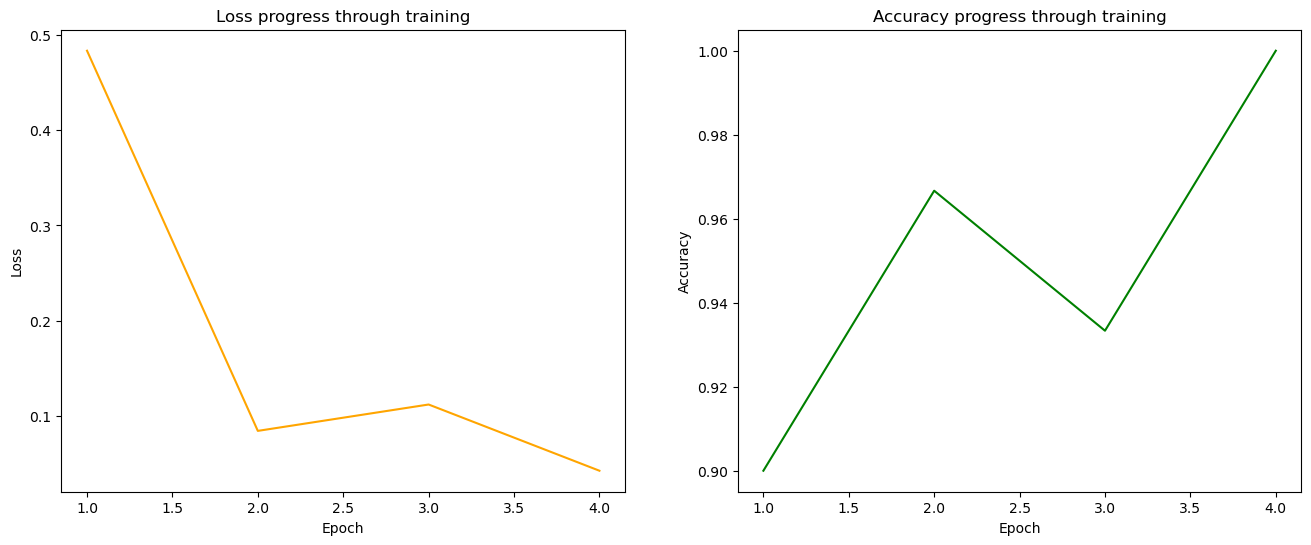

In [53]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

In [54]:
# Loading the best model
resnet_checkpoint = torch.load(PATH)
resnet.load_state_dict(resnet_checkpoint['state_dict'])

<All keys matched successfully>

In [55]:
# Getting the validation accuracy and loss
val_acc, val_loss = evaluate(resnet, val_loader)

print("\n\nValidation accuracy: {:.4f}".format(round(val_acc, 4)))
print("Validation loss: {:.4f}".format(round(val_loss, 4)))

Progress: [====================] 34/34

Validation accuracy: 0.9263
Validation loss: 0.2346


There has been a slight increase in the validation accuracy. 

Let's create a submission file for the test set and see if we get better results on the test set.

In [56]:
predictions = []
test_df = test_df.drop("Class", axis=1)
test_len = len(test_df)

with torch.no_grad():
    for idx in test_df.index:
        data_input = (
            spec_to_image(get_melspectrogram_db(test_time_series[idx].numpy(), test_sr))
            / 255
        )
        data_input = torch.Tensor(data_input).unsqueeze(0)
        output = resnet(data_input.unsqueeze(0))
        _, predicted = torch.max(output, dim=1)
        predictions.append(classes[predicted[0].item()])

        utils.drawProgressBar(idx + 1, test_len, barLen=40)

test_df["Class"] = pd.Series(predictions)
test_df.to_csv("./predictions/TestPredUsingSpecImgResNet.csv", index=False)

Progress: [========================================] 3297/3297

There are still a lot of hyperparameter tuning that we can try to improve the accuracy. We can also try other pre-trained models and see how they perform on this data!

But 65% is a good accuracy for this kind of dataset with 10 classes, and I will continue to try other things on this data and encorage you to do the same!